# Analyse des Données Météorologiques ERA5 pour les Incendies (PACA & Nouvelle-Aquitaine)

### 1. Introduction
Ce notebook analyse les données météorologiques issues de la réanalyse **ERA5-Land**, fournies par le [Climate Data Store de Copernicus](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=download).  
ERA5 fournit des données horaires haute résolution sur de nombreuses variables climatiques : température, précipitations, humidité du sol, rayonnement solaire, vent, etc.

### Contexte d’extraction

En raison des limitations de téléchargement via l’API Copernicus (temps et volume), seules les données des **15 mois les plus dévastateurs** (en termes de surface brûlée) ont été extraites pour les régions **PACA** et **Nouvelle-Aquitaine**.  
Cette extraction ciblée a permis de se concentrer sur les événements les plus marquants.

Les traitements de nettoyage, de normalisation et d’enrichissement (ajout de l’`id_incendie`) ont été réalisés via des scripts dans le dossier :
projet_incendies\scripts\Extraction_Traitement_Donnees\era5

Chaque enregistrement météo est ainsi directement **associé à un incendie** spécifique, facilitant les analyses croisées.

### Objectifs de ce notebook

- Nettoyer et organiser les données météo associées aux incendies.
- Évaluer la qualité et la complétude des variables.
- Identifier les éventuelles anomalies physiques.
- Visualiser les distributions des variables météorologiques.

---


#### 2. Chargement des bibliothèques Python
Nous importons les bibliothèques nécessaires à l’analyse et à la visualisation :

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

#### 3. Chargement des fichiers météo ERA5 (format CSV)

Les fichiers contiennent les données horaires ERA5 extraites autour des incendies pour les deux régions :
- `donnees_meteo_ERA5_NA.csv` (Nouvelle-Aquitaine)
- `donnees_meteo_ERA5_PACA.csv` (PACA)

In [20]:
df_na = pd.read_csv(r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\final\ERA5\donnees_meteo_ERA5_NA.csv", sep=";", encoding="utf-8-sig")
df_paca = pd.read_csv(r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\final\ERA5\donnees_meteo_ERA5_PACA.csv", sep=";", encoding="utf-8-sig")

## 4. Renommage des colonnes pour une meilleure lisibilité
Les noms de colonnes bruts sont remplacés par des noms plus explicites.

In [21]:
def nettoyer_df_era5(df):
    return df.rename(columns={
        "datetime": "date_heure",
        "lat": "latitude",
        "lon": "longitude",
        "t2m": "temperature_air_k",
        "tp": "precipitations_m",
        "swvl1": "humidite_sol_surface_m3m3",
        "ssrd": "rayonnement_solaire_jm2",
        "pev": "evaporation_potentielle_m",
        "u10": "vent_u10_m_s",
        "v10": "vent_v10_m_s",
        "lai_hv": "indice_feuillage_m2m2"
    })

# Application aux deux DataFrames
df_na = nettoyer_df_era5(df_na)
df_paca = nettoyer_df_era5(df_paca)

print("Colonnes Nouvelle-Aquitaine :", df_na.columns.tolist())
print("\n Colonnes PACA :", df_paca.columns.tolist())


Colonnes Nouvelle-Aquitaine : ['id_incendie', 'date_heure', 'temperature_air_k', 'precipitations_m', 'humidite_sol_surface_m3m3', 'rayonnement_solaire_jm2', 'evaporation_potentielle_m', 'vent_u10_m_s', 'vent_v10_m_s', 'indice_feuillage_m2m2', 'latitude', 'longitude']

 Colonnes PACA : ['id_incendie', 'date_heure', 'temperature_air_k', 'precipitations_m', 'humidite_sol_surface_m3m3', 'rayonnement_solaire_jm2', 'evaporation_potentielle_m', 'vent_u10_m_s', 'vent_v10_m_s', 'indice_feuillage_m2m2', 'latitude', 'longitude']


#### 5. Réorganisation des colonnes (ID, date, coordonnées en priorité)

In [22]:
def reordonner_colonnes(df):
    # Colonnes à déplacer
    colonnes_prioritaires = ["id_incendie", "datetime" if "datetime" in df.columns else "date_heure", "latitude", "longitude"]
    # Les autres colonnes, dans leur ordre actuel, sauf celles déjà déplacées
    autres_colonnes = [col for col in df.columns if col not in colonnes_prioritaires]
    # Nouvelle organisation
    colonnes_finales = colonnes_prioritaires + autres_colonnes
    return df[colonnes_finales]

# Appliquer la réorganisation
df_na = reordonner_colonnes(df_na)
df_paca = reordonner_colonnes(df_paca)

# Vérification
print("Nouvelles colonnes NA :", df_na.columns.tolist())
print("Nouvelles colonnes PACA :", df_paca.columns.tolist())


Nouvelles colonnes NA : ['id_incendie', 'date_heure', 'latitude', 'longitude', 'temperature_air_k', 'precipitations_m', 'humidite_sol_surface_m3m3', 'rayonnement_solaire_jm2', 'evaporation_potentielle_m', 'vent_u10_m_s', 'vent_v10_m_s', 'indice_feuillage_m2m2']
Nouvelles colonnes PACA : ['id_incendie', 'date_heure', 'latitude', 'longitude', 'temperature_air_k', 'precipitations_m', 'humidite_sol_surface_m3m3', 'rayonnement_solaire_jm2', 'evaporation_potentielle_m', 'vent_u10_m_s', 'vent_v10_m_s', 'indice_feuillage_m2m2']


### 4. Évaluation de la qualité des données ERA5

Cette étape évalue la qualité des données météorologiques pour chaque région :

- Analyse des colonnes numériques
- Calcul du taux de valeurs manquantes (`NaN`), minimum, maximum.
- Affichage de quelques exemples de valeurs.
- Visualisation du taux de `NaN` par variable sous forme de graphique.

L’objectif est d’identifier les variables problématiques ou incomplètes avant l’analyse.

In [23]:
def evaluer_qualite(
    df: pd.DataFrame,
    nom_region: str,
    afficher: bool = True,
    enregistrer_fig: Optional[str] = None  # chemin pour enregistrer la figure
) -> pd.DataFrame:
    if afficher:
        print(f"\n=== Qualité des données ERA5 : {nom_region} ===")

    colonnes_numeriques = df.select_dtypes(include=["float", "int"]).columns
    colonnes_numeriques = [col for col in colonnes_numeriques if col not in ["latitude", "longitude"]]

    resultats = []

    for col in colonnes_numeriques:
        serie = df[col]
        nb_total = len(serie)
        nb_nan = serie.isna().sum()
        taux_nan = nb_nan / nb_total * 100

        exemples = serie.dropna()
        if len(exemples) >= 5:
            exemples = exemples.sample(5, random_state=42).tolist()
        else:
            exemples = exemples.tolist()

        resultats.append({
            "Colonne": col,
            "Taux NaN (%)": round(taux_nan, 2),
            "Nb valeurs manquantes": nb_nan,
            "Min": round(serie.min(), 3) if not serie.isna().all() else None,
            "Max": round(serie.max(), 3) if not serie.isna().all() else None,
            "Exemples": exemples
        })

    df_resultats = pd.DataFrame(resultats).sort_values("Taux NaN (%)", ascending=False).reset_index(drop=True)

    if afficher:
        display(df_resultats)
        # Courbe
        plt.figure(figsize=(12, 6))
        barplot = sns.barplot(
            data=df_resultats,
            x="Colonne",
            y="Taux NaN (%)",
            hue="Colonne",
            palette="viridis",
            legend=False
        )
        plt.title(f"Taux de valeurs manquantes par variable ({nom_region})")
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 100)
        plt.tight_layout()

        if enregistrer_fig:
            plt.savefig(enregistrer_fig, dpi=300)
        plt.show()

    return df_resultats

#### 4.1. Évaluation de la qualité des données ERA5 pour Nouvelle-Aquitaine


=== Qualité des données ERA5 : Nouvelle-Aquitaine ===


,Colonne,Taux NaN (%),Nb valeurs manquantes,Min,Max,Exemples
0,temperature_air_k,1.2,59,271.711,3.145980e+02,"[293.2563, 285.24255, 310.60962, 285.57864, 29..."
1,evaporation_potentielle_m,1.2,59,-0.070,0.000000e+00,"[-0.0077344226, -0.007191018, -0.016609494, -0..."
2,precipitations_m,1.2,59,0.000,1.700000e-02,"[0.0, 0.0, 3.022303e-05, 0.0, 0.0]"
3,humidite_sol_surface_m3m3,1.2,59,0.052,4.330000e-01,"[0.20596671, 0.2925189, 0.14126146, 0.16785401..."
4,rayonnement_solaire_jm2,1.2,59,0.000,3.024377e+07,"[25954944.0, 19402284.0, 15669402.0, 26414608...."
5,vent_v10_m_s,1.2,59,-5.233,8.131000e+00,"[-1.9061918, -5.2329745, 0.25949562, -3.121427..."
6,vent_u10_m_s,1.2,59,-6.446,7.268000e+00,"[-1.3194818, -2.9444857, 1.3631897, -4.2305717..."
7,indice_feuillage_m2m2,1.2,59,1.532,4.667000e+00,"[2.0307207, 3.1325653, 3.2439547, 2.0493422, 3..."
8,id_incendie,0.0,0,138.000,5.876000e+03,"[264, 5875, 3200, 4719, 5711]"


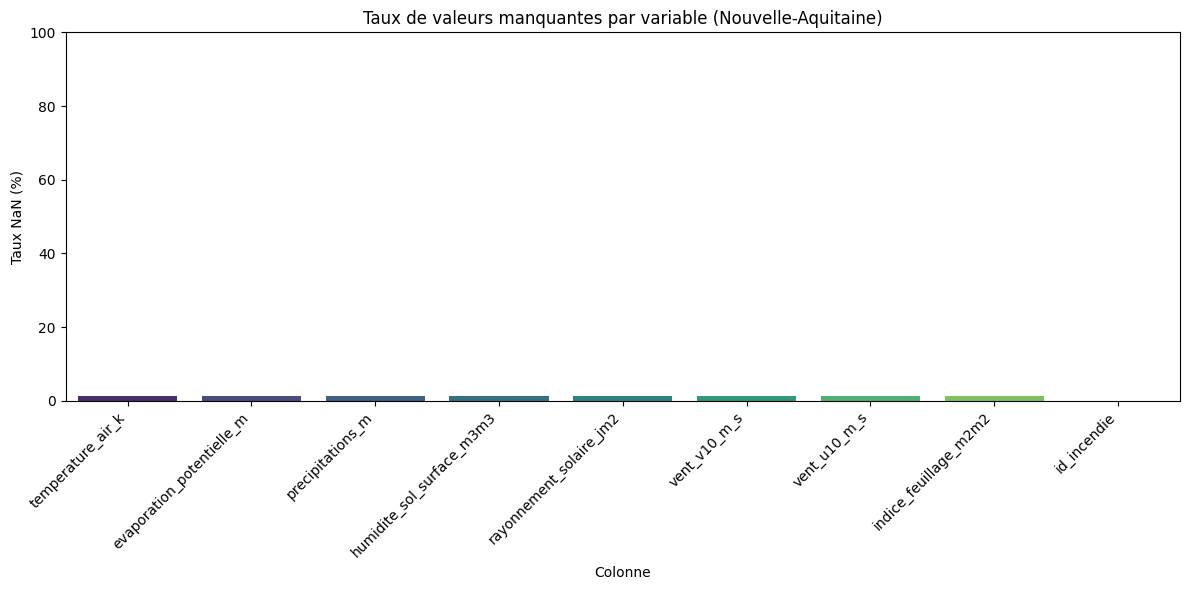

In [24]:
qualite_na = evaluer_qualite(df_na, "Nouvelle-Aquitaine", afficher=True, enregistrer_fig=None)

#### 4.2. Évaluation de la qualité des données ERA5 pour PACA


=== Qualité des données ERA5 : PACA ===


,Colonne,Taux NaN (%),Nb valeurs manquantes,Min,Max,Exemples
0,temperature_air_k,1.16,56,269.283,3.111660e+02,"[305.22058, 294.68665, 297.92252, 293.25217, 3..."
1,evaporation_potentielle_m,1.16,56,-0.040,0.000000e+00,"[-0.010342176, -0.014484365, -0.016246853, -0...."
2,precipitations_m,1.16,56,0.000,2.000000e-02,"[4.2617322e-07, 0.00028965535, 0.0019698527, 1..."
3,humidite_sol_surface_m3m3,1.16,56,0.068,4.690000e-01,"[0.13171858, 0.16525295, 0.15892851, 0.1514079..."
4,rayonnement_solaire_jm2,1.16,56,0.000,3.042529e+07,"[18797128.0, 27433160.0, 20980504.0, 9014198.0..."
5,vent_v10_m_s,1.16,56,-10.584,7.320000e+00,"[1.923481, -5.6200304, 0.85757315, -6.0216417,..."
6,vent_u10_m_s,1.16,56,-8.729,9.529000e+00,"[3.4461355, 3.6442232, 0.95823836, 2.4811716, ..."
7,indice_feuillage_m2m2,1.16,56,0.544,4.893000e+00,"[2.965333, 1.5146775, 2.7018566, 2.2650137, 1...."
8,id_incendie,0.00,0,102.000,5.963000e+03,"[5796, 2676, 3219, 2614, 3385]"


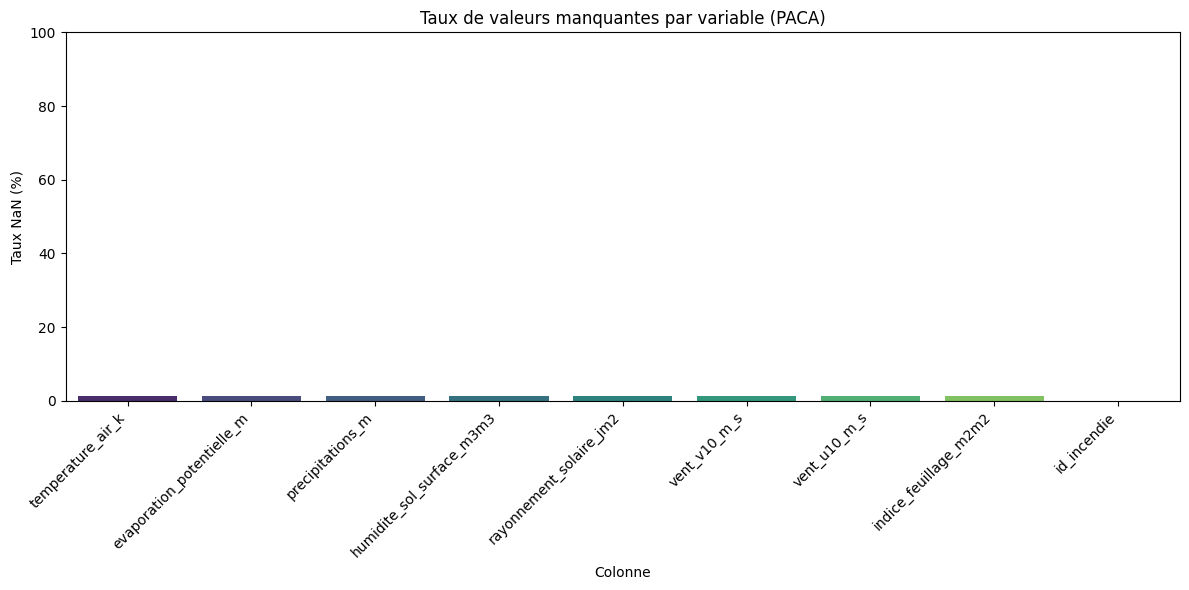

In [25]:
qualite_paca = evaluer_qualite(df_paca, "PACA", afficher=True, enregistrer_fig=None)

#### 5. Interprétation de la qualité des données ERA5 (NA & PACA)

Les deux régions présentent une **qualité de données globalement très satisfaisante** :

- Le taux de valeurs manquantes est **faible (~1.2%)** pour l'ensemble des variables météorologiques, en **Nouvelle-Aquitaine** comme en **PACA**.
- Aucune variable ne présente un niveau de complétude critique ou une structure inutilisable.
- Les plages de valeurs (`min` / `max`) sont **physiquement cohérentes** pour les principales variables (température, vent, humidité, etc.).
- Quelques **valeurs négatives** sont observées pour **l'évaporation** : un contrôle complémentaire peut être effectué pour valider leur validité physique dans le contexte ERA5.

**Conclusion** : les données sont **suffisamment propres pour l’analyse descriptive et comparative**. Aucun filtrage intensif n’est requis à ce stade.

---

#### Concernant la variable `pev` (Évaporation Potentielle)

La variable `pev` (Potential Evaporation) issue des données **ERA5** représente un flux d'évaporation potentielle en **mètres (m)**. Selon les conventions du **Centre Européen pour les Prévisions Météorologiques à Moyen Terme (ECMWF)** :

- **Flux vers le bas** (vers la surface) : considéré comme **positif**.
- **Flux vers le haut** (depuis la surface vers l'atmosphère) : considéré comme **négatif**.

#### Interprétation des valeurs de `pev` :

- **Valeur négative** de `pev` : indique une **évaporation active** (eau quittant le sol vers l’air).
- **Valeur positive** : traduirait une **condensation** (retour d’eau vers le sol, par exemple via la rosée), bien que cela soit plus rare.

#### Observations sur le jeu de données :

Dans notre jeu de données, la grande majorité des valeurs de `pev` sont **négatives**, ce qui est **cohérent** avec un processus d’évaporation dominant, notamment en été ou dans des conditions sèches.

---

#### 6. Détection d'anomalies physiques

Afin de garantir la qualité des données météorologiques avant toute modélisation, nous définissons des **seuils physiques plausibles** pour détecter d’éventuelles **valeurs aberrantes** dans les jeux de données.

#### Seuils retenus pour la détection

| Variable                               | Unité     | Intervalle plausible        | Remarques                                     |
|----------------------------------------|-----------|------------------------------|-----------------------------------------------|
| Température de l’air (`temperature_air_k`)        | Kelvin     | 0 K – 330 K                  | Soit ~ -273°C à 57°C                          |
| Précipitations (`precipitations_m`)              | m/h        | 0 – 0.5 m/h                  | Équivalent à 500 mm/h                         |
| Évaporation potentielle (`evaporation_potentielle_m`) | m/h        | -0.07 – 0.01 m/h             | Valeurs négatives possibles, à vérifier       |

#### Méthodologie

Une **fonction automatique** de contrôle qualité est appliquée sur les deux fichiers météo régionaux (`Nouvelle-Aquitaine` et `PACA`).  
Elle vérifie, pour chaque observation, si les valeurs mesurées respectent les plages attendues.

#### Objectif

Cette étape permet :
- de **valider la fiabilité des données** météorologiques issues d'ERA5,
- d’**identifier rapidement les anomalies éventuelles**,
- et de garantir des analyses cohérentes dans la suite du projet.


In [26]:
# --- 1. Définir les seuils physiques plausibles ---
seuils = {
    "temperature_air_k": (0, 330),         # [0 K, ~57°C]
    "precipitations_m": (0, 0.5),          # [0, 0.5m] soit 500 mm/h max raisonnable
    "evaporation_potentielle_m": (-0.07, 0.01) # [-70 mm/h, +10 mm/h]
}

# --- 2. Fonction de détection des anomalies sur un DataFrame ---
def detecter_anomalies(df, nom_df):
    print(f"\n Analyse des anomalies dans : {nom_df}")
    anomalies = {}

    for col, (min_val, max_val) in seuils.items():
        if col in df.columns:
            df_anom = df[(df[col] < min_val) | (df[col] > max_val)]
            anomalies[col] = df_anom

            print(f" {col} : {len(df_anom)} anomalies")
            if not df_anom.empty:
                print(f"   Index exemples : {df_anom.index[:5].tolist()}")
                print(f"   Valeurs suspectes :\n{df_anom[[col]].head(3)}\n")
        else:
            print(f"Colonne {col} absente dans {nom_df}")

    # Concaténer toutes les lignes contenant au moins une anomalie
    df_total = pd.concat(anomalies.values()).drop_duplicates()
    print(f"Total de lignes uniques avec anomalies dans {nom_df} : {len(df_total)}")
    
    return df_total

# --- 3. Appliquer sur les deux DataFrames ---
anomalies_na = detecter_anomalies(df_na, "Nouvelle-Aquitaine")
anomalies_paca = detecter_anomalies(df_paca, "PACA")



 Analyse des anomalies dans : Nouvelle-Aquitaine
 temperature_air_k : 0 anomalies
 precipitations_m : 0 anomalies
 evaporation_potentielle_m : 0 anomalies
Total de lignes uniques avec anomalies dans Nouvelle-Aquitaine : 0

 Analyse des anomalies dans : PACA
 temperature_air_k : 0 anomalies
 precipitations_m : 0 anomalies
 evaporation_potentielle_m : 0 anomalies
Total de lignes uniques avec anomalies dans PACA : 0


#### Résultats de l’analyse

Aucune anomalie détectée dans les deux régions analysées :

- **Nouvelle-Aquitaine** :
  - `temperature_air_k` : 0 anomalies
  - `precipitations_m` : 0 anomalies
  - `evaporation_potentielle_m` : 0 anomalies  
  → **Aucune ligne contenant des valeurs hors seuil.**

- **PACA** :
  - `temperature_air_k` : 0 anomalies
  - `precipitations_m` : 0 anomalies
  - `evaporation_potentielle_m` : 0 anomalies  
  → **Aucune ligne contenant des valeurs hors seuil.**

**Conclusion** : Les données météorologiques ERA5 sont **cohérentes et fiables** pour les deux régions. Aucune valeur physiquement aberrante n’a été détectée.

---

#### 7. Conversion des unités physiques (ERA5)

Les données météorologiques issues d’ERA5 sont fournies dans des **unités standards SI**, peu interprétables directement.  
Nous appliquons ici une **fonction de nettoyage et de conversion** pour les adapter à des unités plus couramment utilisées :

- **Température de l'air** : convertie de **Kelvin (K)** vers **Celsius (°C)**  
- **Précipitations** : converties de **mètres (m)** vers **millimètres (mm)**  
- **Évaporation potentielle** : convertie de **mètres (m)** vers **millimètres (mm)**,nous avons également appliqué la fonction abs() afin de rendre toutes les valeurs positives, exprimant ainsi l’évaporation de manière cohérente.

Cette fonction gère également la **présence éventuelle de valeurs manquantes (`NaN`)**.

In [27]:
def nettoyer_et_convertir_era5(df):
    # Renommer les colonnes
    df = df.rename(columns={
        "temperature_air_k": "temperature_air_c",
        "precipitations_m": "precipitations_mm",
        "evaporation_potentielle_m": "evaporation_potentielle_mm"
    })

    # Conversion des unités avec gestion des NaN
    if "temperature_air_c" in df.columns:
        df["temperature_air_c"] = df["temperature_air_c"].apply(
            lambda x: x - 273.15 if pd.notna(x) else x
        )
    if "precipitations_mm" in df.columns:
        df["precipitations_mm"] = df["precipitations_mm"].apply(
            lambda x: x * 1000 if pd.notna(x) else x
        )
    if "evaporation_potentielle_mm" in df.columns:
        df["evaporation_potentielle_mm"] = df["evaporation_potentielle_mm"].apply(
            lambda x: abs(x * 1000) if pd.notna(x) else x
        )
    return df

# Application sur les deux dataframes
df_paca = nettoyer_et_convertir_era5(df_paca)
df_na = nettoyer_et_convertir_era5(df_na)

#### 8. Analyse statistique et distribution des variables ERA5

Nous comparons ici les distributions des principales variables météorologiques issues d’ERA5 entre les régions PACA et Nouvelle-Aquitaine, après conversion des unités :

- **Température de l’air (°C)**
- **Précipitations (mm)**
- **Évaporation potentielle (mm)**

### Résumé statistique

Nous calculons les statistiques descriptives classiques (moyenne, médiane, écart-type, min, max, etc.) pour chacune des variables sélectionnées dans les deux régions.

In [28]:
colonnes_a_analyser = ["temperature_air_c", "precipitations_mm", "evaporation_potentielle_mm"]

print("Résumé statistique PACA :")
print(df_paca[colonnes_a_analyser].describe(), "\n")

print("\n Résumé statistique Nouvelle-Aquitaine :")
print(df_na[colonnes_a_analyser].describe())
print("\n Colonnes Nouvelle-Aquitaine :", df_na.columns.tolist())
print("\n Colonnes PACA :", df_paca.columns.tolist())

Résumé statistique PACA :
       temperature_air_c  precipitations_mm  evaporation_potentielle_mm
count        4762.000000        4762.000000                 4762.000000
mean           23.539160           0.293710                    6.843253
std             6.875544           1.419383                    4.731952
min            -3.866980           0.000000                    0.000012
25%            20.178763           0.000000                    3.182916
50%            24.587880           0.000852                    6.552637
75%            28.389488           0.016304                    9.743796
max            38.015700          20.078538                   39.500177 


 Résumé statistique Nouvelle-Aquitaine :
       temperature_air_c  precipitations_mm  evaporation_potentielle_mm
count        4863.000000        4863.000000                 4863.000000
mean           23.773597           0.329965                   10.133999
std             6.660070           1.199304                    7.9

### 8.1. Visualisation des distributions

Les histogrammes ci-dessous permettent de visualiser la forme des distributions pour chaque variable, en comparant les deux régions côte à côte :

- **À gauche** : distribution pour la région PACA
- **À droite** : distribution pour la région Nouvelle-Aquitaine

Cela permet de repérer visuellement les différences de climat ou de régime hydrique entre les deux territoires.


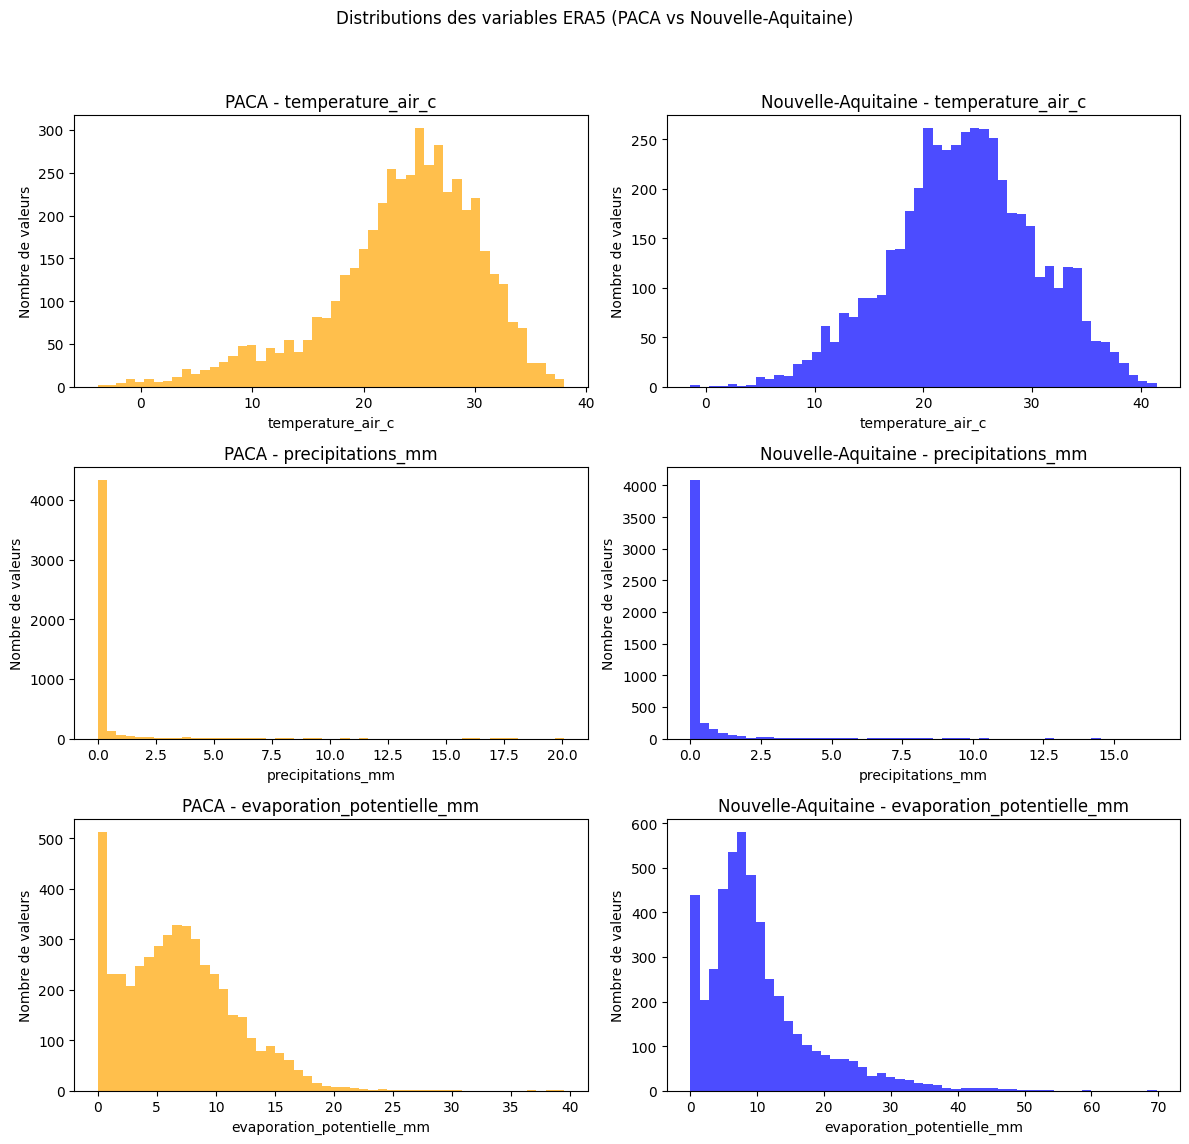

In [29]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle("Distributions des variables ERA5 (PACA vs Nouvelle-Aquitaine)")

for i, col in enumerate(colonnes_a_analyser):
    axs[i, 0].hist(df_paca[col].dropna(), bins=50, color='orange', alpha=0.7)
    axs[i, 0].set_title(f"PACA - {col}")
    axs[i, 0].set_xlabel(col)
    axs[i, 0].set_ylabel("Nombre de valeurs")

    axs[i, 1].hist(df_na[col].dropna(), bins=50, color='blue', alpha=0.7)
    axs[i, 1].set_title(f"Nouvelle-Aquitaine - {col}")
    axs[i, 1].set_xlabel(col)
    axs[i, 1].set_ylabel("Nombre de valeurs")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Interprétation des distributions des variables ERA5 (PACA vs Nouvelle-Aquitaine)

Cette section présente une comparaison des distributions des principales variables météorologiques entre les régions PACA et Nouvelle-Aquitaine.

#### - Température de l’air (temperature_air_c)

- **PACA** : moyenne de **23.5 °C**, avec des valeurs entre **-3.9 °C** et **38 °C**. La distribution est centrée autour de **24–28 °C**, typique d’un climat chaud et stable.
  
- **Nouvelle-Aquitaine** : moyenne légèrement supérieure (**23.8 °C**), avec une plage plus étendue (**-1.4 °C à 41.4 °C**), reflétant une variabilité thermique plus forte.

**Conclusion** : La Nouvelle-Aquitaine présente une amplitude thermique plus importante, liée à un climat plus contrasté.

#### - Précipitations (precipitations_mm)

- **PACA** : moyenne de **0.29 mm**, avec une majorité de jours secs (valeurs proches de **0**). Quelques épisodes intenses (> **10 mm**) sont observés.
  
- **Nouvelle-Aquitaine** : moyenne légèrement supérieure (**0.33 mm**), avec des pluies plus fréquentes mais moins extrêmes.

**Conclusion** : PACA a un climat plus sec avec des épisodes pluvieux soudains, tandis que la Nouvelle-Aquitaine connaît des précipitations plus régulières.

#### - Évaporation potentielle (evaporation_potentielle_mm)

- **PACA** : moyenne de **6.8 mm**, distribution concentrée autour de **5–10 mm**.
  
- **Nouvelle-Aquitaine** : moyenne plus élevée (**10.1 mm**), avec une distribution étalée vers les fortes valeurs (jusqu’à **70 mm**).

**Conclusion** : L’évaporation est plus intense en Nouvelle-Aquitaine, ce qui peut accentuer le stress hydrique.

#### - Synthèse

| Variable        | PACA                      | Nouvelle-Aquitaine                |
|------------------|---------------------------|-----------------------------------|
| Température      | Chaude, stable            | Amplitude thermique plus large     |
| Précipitations    | Rares mais intenses       | Plus fréquentes, moins extrêmes    |
| Évaporation      | Modérée (~6.8 mm)        | Élevée et variable (~10.1 mm)     |

---


#### 9. Suppression des lignes vides sur les variables météorologiques

Pour garantir la qualité des données, nous avons supprimé les lignes ne contenant **aucune valeur sur les principales variables météorologiques** listées ci-dessous :

- `temperature_air_c`
- `precipitations_mm`
- `humidite_sol_surface_m3m3`
- `rayonnement_solaire_jm2`
- `evaporation_potentielle_mm`
- `vent_u10_m_s`
- `vent_v10_m_s`
- `indice_feuillage_m2m2`

Cette étape permet de supprimer uniquement les **lignes totalement vides** sur les variables météo, en conservant les lignes partiellement remplies qui restent exploitables pour l’analyse.

In [30]:
# Liste des variables météo à vérifier
colonnes_meteo = [
    'temperature_air_c', 'precipitations_mm', 'humidite_sol_surface_m3m3',
    'rayonnement_solaire_jm2', 'evaporation_potentielle_mm',
    'vent_u10_m_s', 'vent_v10_m_s', 'indice_feuillage_m2m2'
]

# --- Nouvelle-Aquitaine (NA) ---
# Compter le nombre de lignes avant suppression
lignes_avant_na = len(df_na)
print(f"[NA] Lignes avant suppression : {lignes_avant_na}")

# Supprimer les lignes 100% vides sur les colonnes météo
df_na = df_na.dropna(subset=colonnes_meteo, how='all')

# Compter le nombre de lignes après suppression
lignes_apres_na = len(df_na)
lignes_supprimees_na = lignes_avant_na - lignes_apres_na
print(f"[NA] Lignes après suppression : {lignes_apres_na}")
print(f"[NA] Lignes supprimées : {lignes_supprimees_na}")

# --- PACA ---
# Compter le nombre de lignes avant suppression
lignes_avant_paca = len(df_paca)
print(f"\n[PACA] Lignes avant suppression : {lignes_avant_paca}")

# Supprimer les lignes 100% vides sur les colonnes météo
df_paca = df_paca.dropna(subset=colonnes_meteo, how='all')

# Compter le nombre de lignes après suppression
lignes_apres_paca = len(df_paca)
lignes_supprimees_paca = lignes_avant_paca - lignes_apres_paca
print(f"[PACA] Lignes après suppression : {lignes_apres_paca}")
print(f"[PACA] Lignes supprimées : {lignes_supprimees_paca}")

[NA] Lignes avant suppression : 4922
[NA] Lignes après suppression : 4863
[NA] Lignes supprimées : 59

[PACA] Lignes avant suppression : 4818
[PACA] Lignes après suppression : 4762
[PACA] Lignes supprimées : 56


### 9.1. Vérification des valeurs manquantes

Après suppression des lignes totalement vides sur les variables météorologiques, nous vérifions :

- Les colonnes encore concernées par des valeurs manquantes,
- Le nombre de lignes entièrement vides,
- Le nombre de lignes partiellement incomplètes (au moins une valeur manquante).

In [31]:
def verifier_valeurs_vides(df, nom_df):
    print(f"\n=== Vérification des valeurs manquantes dans {nom_df} ===")

    # Vérifier les colonnes avec des valeurs manquantes
    colonnes_vides = df.isnull().sum()
    colonnes_vides = colonnes_vides[colonnes_vides > 0]
    if colonnes_vides.empty:
        print("Aucune colonne avec des valeurs manquantes.")
    else:
        print("Colonnes avec valeurs manquantes :")
        print(colonnes_vides)

    # Vérifier les lignes entièrement vides
    lignes_vides = df.isnull().all(axis=1).sum()
    print(f"\nNombre de lignes entièrement vides : {lignes_vides}")

    # Vérifier les lignes partiellement vides
    lignes_partielles = df.isnull().any(axis=1).sum()
    print(f"Nombre de lignes avec au moins une valeur manquante : {lignes_partielles}")

# Vérification sur les deux DataFrames
verifier_valeurs_vides(df_na, "Nouvelle-Aquitaine")
verifier_valeurs_vides(df_paca, "PACA")



=== Vérification des valeurs manquantes dans Nouvelle-Aquitaine ===
Aucune colonne avec des valeurs manquantes.

Nombre de lignes entièrement vides : 0
Nombre de lignes avec au moins une valeur manquante : 0

=== Vérification des valeurs manquantes dans PACA ===
Aucune colonne avec des valeurs manquantes.

Nombre de lignes entièrement vides : 0
Nombre de lignes avec au moins une valeur manquante : 0


## 10. Vérification des jours disponibles par mois et par région

Nous vérifions la couverture temporelle des données météorologiques en identifiant les jours disponibles pour chaque mois et chaque année, dans les deux régions analysées : Nouvelle-Aquitaine et PACA.

Cela permet de s'assurer que les périodes d'intérêt (dates des incendies) sont bien couvertes par les données météo.

In [36]:
def extraire_jours_par_mois(df, nom_region="Région"):
    df = df.copy()
    df["date_heure"] = pd.to_datetime(df["date_heure"])
    df["année"] = df["date_heure"].dt.year
    df["mois"] = df["date_heure"].dt.month
    df["jour"] = df["date_heure"].dt.day

    print(f"\n--- {nom_region.upper()} ---")
    années = sorted(df["année"].unique())
    
    for an in années:
        print(f"\nAnnée {an} :")
        mois_disponibles = sorted(df[df["année"] == an]["mois"].unique())
        for mois in mois_disponibles:
            jours_numpy = df[(df["année"] == an) & (df["mois"] == mois)]["jour"].unique()
            jours = sorted(map(int, jours_numpy))  # <- conversion ici
            print(f"  Mois {mois:02d} : jours disponibles → {jours}")

# Appel de la fonction
extraire_jours_par_mois(df_na, "Nouvelle-Aquitaine")
extraire_jours_par_mois(df_paca, "PACA")


--- NOUVELLE-AQUITAINE ---

Année 2010 :
  Mois 04 : jours disponibles → [2, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30]

Année 2011 :
  Mois 07 : jours disponibles → [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 22, 23, 28, 29, 30]

Année 2012 :
  Mois 08 : jours disponibles → [1, 3, 4, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

Année 2015 :
  Mois 07 : jours disponibles → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31]

Année 2016 :
  Mois 09 : jours disponibles → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30]

Année 2017 :
  Mois 04 : jours disponibles → [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30]
  Mois 07 : jours disponibles → [2, 5, 6, 7, 8, 13, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31]

Année 2019 :
  Mois 07

#### 11. Sauvegarde des fichiers nettoyés
Les jeux de données finaux sont enregistrés dans des fichiers `.csv` prêts pour l’analyse descriptive.

In [33]:
chemin_na = r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_era5_nettoyes_na.csv"
chemin_paca = r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_era5_nettoyes_paca.csv"

# Sauvegarder les fichiers
df_na.to_csv(chemin_na, index=False, sep=";", encoding="utf-8-sig")
df_paca.to_csv(chemin_paca, index=False,sep=";", encoding="utf-8-sig")

print("Fichiers sauvegardés avec succès :")
print(f"- {chemin_na}")
print(f"- {chemin_paca}")

Fichiers sauvegardés avec succès :
- C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_era5_nettoyes_na.csv
- C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_era5_nettoyes_paca.csv
